<a href="https://colab.research.google.com/github/TanguyM-cloud/Finance-projects-Python-/blob/main/Stock's_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrez le ticker (ex: AAPL, MC.PA) : MC.PA


/tmp/ipython-input-1879641417.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker_input, msci_proxy], period="5y", interval="1mo")['Close']
[*********************100%***********************]  2 of 2 completed


--- Analyse approfondie de MC.PA ---


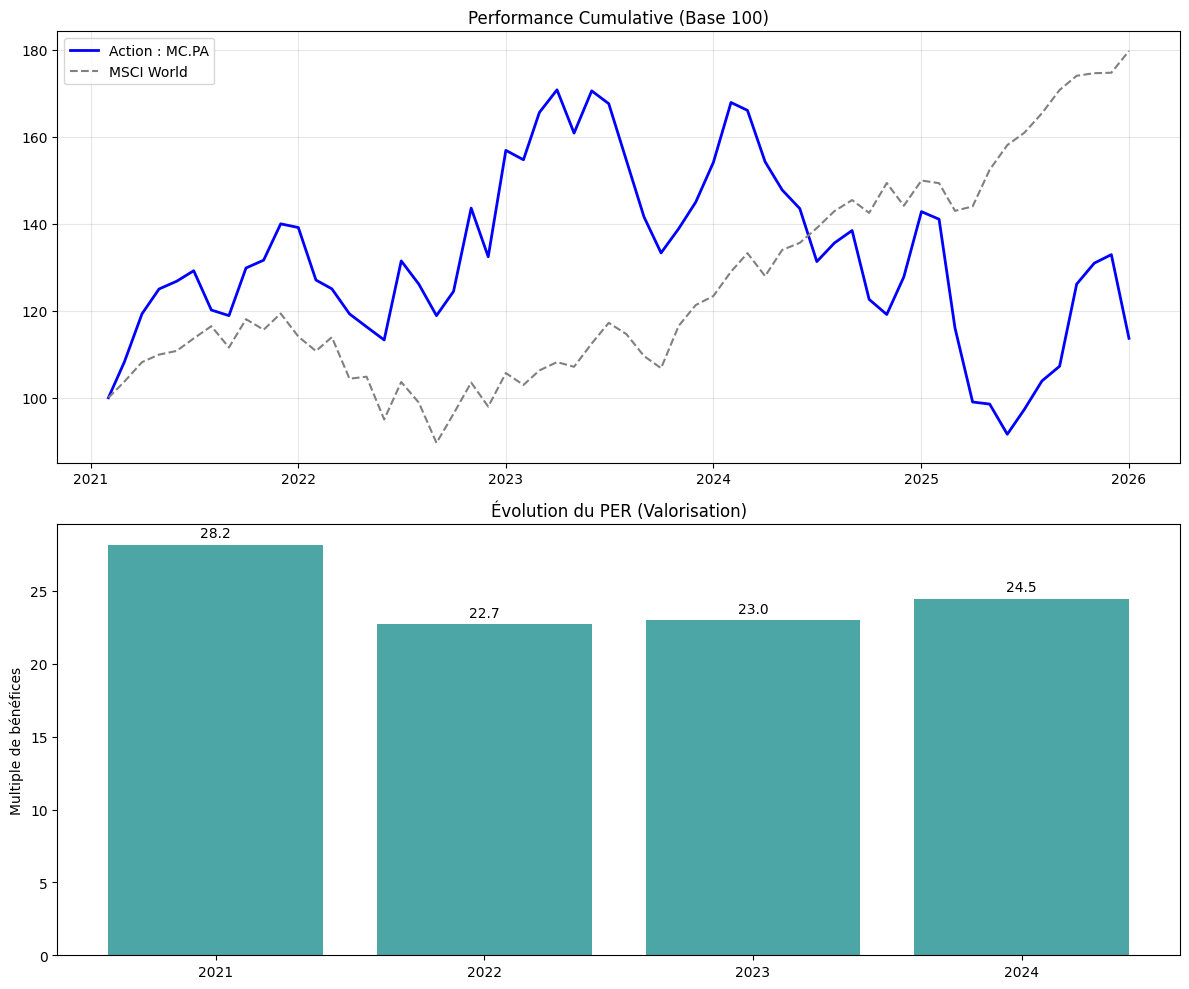


 RÉCAPITULATIF DES RATIOS POUR MC.PA
      EPS (Bénéfice/Action)    PER  Rendement (%)  Payout Ratio (%)
2022                  28.05  22.71           1.88             42.78
2023                  30.34  22.99           1.79             41.20
2024                  25.13  24.47           2.11             51.73
2025                    NaN    NaN           2.03               NaN
2026                    NaN    NaN            NaN               NaN


In [11]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def analyse_action_expert():
    ticker_input = input("Entrez le ticker (ex: AAPL, MC.PA) : ").upper()
    msci_proxy = "URTH"

    print(f"\n--- Analyse approfondie de {ticker_input} ---")

    # 1. Données boursières (Prix)
    ticker_obj = yf.Ticker(ticker_input)
    data = yf.download([ticker_input, msci_proxy], period="5y", interval="1mo")['Close']
    data = data.dropna()

    # 2. Calcul de la Base 100
    returns = data.pct_change().fillna(0)
    base_100 = (1 + returns).cumprod() * 100

    # 3. Récupération des fondamentaux (Compte de résultat)
    # .financials nous donne les données annuelles
    income_statement = ticker_obj.financials

    # On cherche le Bénéfice par action (EPS) - On transpose pour avoir les dates en index
    if "Basic EPS" in income_statement.index:
        eps_annuel = income_statement.loc["Basic EPS"].T
    elif "Diluted EPS" in income_statement.index:
        eps_annuel = income_statement.loc["Diluted EPS"].T
    else:
        eps_annuel = pd.Series()

    # 4. Dividendes
    divs = ticker_obj.dividends
    div_annuel = divs.groupby(divs.index.year).sum()

    # 5. Construction du tableau de ratios
    # On aligne tout par année
    closing_prices = data[ticker_input].resample('YE').last()
    closing_prices.index = closing_prices.index.year

    # On prépare les EPS (on extrait l'année de l'index de yfinance)
    if not eps_annuel.empty:
        eps_annuel.index = eps_annuel.index.year

    ratios = pd.DataFrame({
        'Cours Clôture': closing_prices,
        'EPS (Bénéfice/Action)': eps_annuel,
        'Dividende': div_annuel
    }).dropna(subset=['Cours Clôture']) # On garde les années où on a au moins le prix

    # --- Calcul des Ratios ---
    # PER = Prix / Bénéfice par action
    ratios['PER'] = ratios['Cours Clôture'] / ratios['EPS (Bénéfice/Action)']

    # Rendement = Dividende / Prix
    ratios['Rendement (%)'] = (ratios['Dividende'] / ratios['Cours Clôture']) * 100

    # Payout Ratio = Dividende / Bénéfice (Quelle part du profit est versée ?)
    ratios['Payout Ratio (%)'] = (ratios['Dividende'] / ratios['EPS (Bénéfice/Action)']) * 100

    # 6. Affichage des Graphiques
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Graphique 1 : Base 100
    ax1.plot(base_100[ticker_input], label=f"Action : {ticker_input}", color='blue', linewidth=2)
    ax1.plot(base_100[msci_proxy], label="MSCI World", color='gray', linestyle='--')
    ax1.set_title("Performance Cumulative (Base 100)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Graphique 2 : Évolution du PER
    if not ratios['PER'].dropna().empty:
        ax2.bar(ratios.index.astype(str), ratios['PER'], color='teal', alpha=0.7)
        ax2.set_title("Évolution du PER (Valorisation)")
        ax2.set_ylabel("Multiple de bénéfices")
        for i, v in enumerate(ratios['PER']):
            if not pd.isna(v):
                ax2.text(i, v + 0.5, f"{v:.1f}", ha='center')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print(f" RÉCAPITULATIF DES RATIOS POUR {ticker_input}")
    print("="*60)
    print(ratios[['EPS (Bénéfice/Action)', 'PER', 'Rendement (%)', 'Payout Ratio (%)']].tail(5).round(2))
    print("="*60)

if __name__ == "__main__":
    analyse_action_expert()